## Link prediction

Task: http://ns-hseds.ddns.net/web/challenges/challenge-page/37/overview 



### Part 0. Uploading data

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
f = open("node_feat.txt", "r")
lines = f.readlines()
f.close()
N = len(lines)
emb = np.zeros((N, 32))
for k in range(N):
    emb[k] = [float(i) for i in lines[k][:-1].split()]
f = open("train_edges.txt", "r")
lines = f.readlines()
f.close()
M = len(lines)
train = np.zeros((M, 2), dtype='int16')
for k in range(M):
    train[k] = [int(i) for i in lines[k][:-1].split()]
f = open("unlabeled_edges.txt", "r")
lines = f.readlines()
f.close()
L = len(lines)
to_predict = np.zeros((L, 2), dtype='int16')
for k in range(L):
    to_predict[k] = [int(i) for i in lines[k][:-1].split()]

In [3]:
emb.shape, train.shape, to_predict.shape

((12588, 32), (14322, 2), (44014, 2))

### Part 1. Secrets of the dataset

Do you like video games where you need to explore the location, look for secrets, hints?

Let's go back to childhood and find HESOYAM of this data.

#### 1.1. Ordinal numbers make sense

Let's look at the difference in the ordinal numbers of the edges.

In [4]:
diff = train[:,1] - train[:,0]

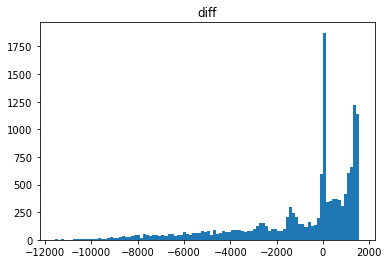

In [5]:
plt.hist(diff, bins=100)
plt.title("diff")
plt.show()

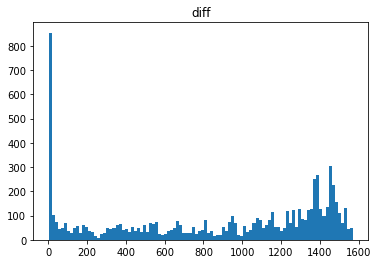

In [6]:
plt.hist(diff[diff>0], bins=100)
plt.title("diff")
plt.show()

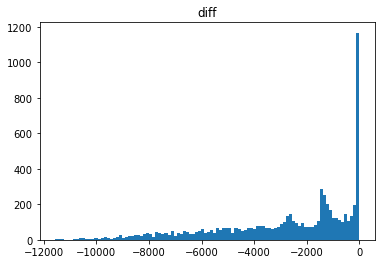

In [8]:
plt.hist(diff[diff<0], bins=100)
plt.title("diff")
plt.show()

Conclusions:
1. A lot of links have close ordinal numbers of the beginning and end.
2. For all links diff > 1600. This is a very powerful knowledge.
Let's use the decisive rule: diff > 1600 leads to a prediction of 0.

#### 1.2. Negative sampling as a killer feature

Two facts:
1. If you pour into the system an answer consisting of all 1, the score will be 0.5. Not 0.500345! Exactly 0.5!
2. Fix the starting node i. For ANY i it turns out that the file unlabeled_edges.txt contains an EVEN number of edges.

In [10]:
for i in range(N):
    if (to_predict[:,0] == i).sum() % 2 == 1:
        print(i)

And now let's read how the baselines were built.

Grade 4: Concatenate node features and train Gradient Boosting with **negative sampling**.

Grade 6: Train GNN with **negative sampling**. GNN consists of encoder and decoder. Encoder is two-layer GCN that takes node features and returns node emebeddings. Decoder is two-layer MLP that takes hadamart product of node embeddings and predicts links.

This means that the compilers of the competition are very fond of **negative sampling**.

This is very similar to the fact that the data was compiled by a method similar to negative sampling.

This means that for any i, the number of edges (i, j) that are link and the number of edges (i, k) that are not link must be equal!

### Part 2. Features and model

Let's briefly describe the action plan:

1. We use as a fact that diff > 1600 automatically leads to a prediction of 0.
2. We will predict the remaining edges using the model.
3. We use negative sampling to train the model. In this case, negative examples will be generated taking into account the condition diff < 1600.
4. The model should return the PROBABILITY that the edge is a reference.
5. We will solve the ranking problem separately for each starting node. There are 2k edges in total for each starting node. The first k edges are assigned the value 1 by the probability of being a link, otherwise 0. So we solve the problem of ranking and we will use ROC AUC instead of accuracy measure.

In [12]:
# negative sampling

set_train = set()
for i in range(M):
    set_train.add(tuple(train[i]))
set_predict = set()
for i in range(L):
    set_predict.add(tuple(to_predict[i]))
y = np.zeros(2*M)
for i in range(M):
    y[i] = 1.0
np.random.seed(42)
neg_train = train.copy()
for i in range(M):
    while tuple(neg_train[i]) in set_train or tuple(neg_train[i]) in set_predict or neg_train[i][0] == neg_train[i][1] or neg_train[i][0] + 1600 < neg_train[i][1]:
        neg_train[i][1] = np.random.randint(N)

To reduce the dimension of embeddings, we will use PCA.

Features:
1. The difference of embeddings
2. The product of embeddings
3. Cosine distance between embedding
4. Our favorite diff metric
5. Frequency of occurrence of the end of the link. The idea is that there are popular works that are often referenced.

6. Let G be a graph where nodes are nodes))) And the edges are known real links

7. The length of the shortest path from the beginning of the edge to the end of the edge. Return 0 if the vertices belong to different connectivity components. When we consider this measure for real links, we must remove the edge corresponding to this link. Otherwise it will always get 1.
The process of removing an edge is very long, so I use the pre-calculated values for this file.

In [14]:
num_link = np.zeros(N)
for i in range(M):
    num_link[train[i][1]] += 1
for i in range(M):
    num_link[neg_train[i][1]] += 1
for i in range(L):
    num_link[to_predict[i][1]] += 1

G = nx.Graph()
G.add_nodes_from(np.arange(N))
G.add_edges_from(train)

f = open("sh_path.txt", "r")
lines = f.readlines()
f.close()
sh_path = np.zeros(2 * M)
for k in range(2*M):
    sh_path[k] = int(lines[k][:-1])

In [16]:
K = 20 # just empirical intuition
pca = PCA(K)
emb_pca = pca.fit_transform(emb)
X = np.zeros((2*M, 2*K+4))
for i in range(M):
    X[i][:K] = emb_pca[train[i][1]] - emb_pca[train[i][0]]
    X[i][K:2*K] = emb_pca[train[i][1]] * emb_pca[train[i][0]]
    X[i][2*K] = cosine(emb[train[i][1]], emb[train[i][0]])
    X[i][2*K+1] = train[i][1] - train[i][0]
    X[i][2*K+2] = num_link[train[i][1]]
    X[i][2*K+3] = sh_path[i]
for i in range(M):
    X[i + M][:K] = emb_pca[neg_train[i][1]] - emb_pca[neg_train[i][0]]
    X[i + M][K:2*K] = emb_pca[neg_train[i][1]] * emb_pca[neg_train[i][0]]
    X[i + M][2*K] = cosine(emb[neg_train[i][1]], emb[neg_train[i][0]])
    X[i + M][2*K+1] = neg_train[i][1] - neg_train[i][0]
    X[i + M][2*K+2] = num_link[neg_train[i][1]]
    X[i + M][2*K+3] = sh_path[i + M]

In [17]:
model = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder = False)
cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()

0.9075085190857664

Wow, a great result!

As you can see, I use XGBoost. This result can be improved by adjusting hyperparameters. This is a boring process, it is described here. https://russianblogs.com/article/2308221344/ I will only show my answer.

In [18]:
model = XGBClassifier(
 learning_rate = 0.01,
 max_depth=5,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic', eval_metric='auc', use_label_encoder = False,
 nthread=4,
 scale_pos_weight=1, reg_alpha=7,
 seed=42)
cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()

0.9013990101327017

Now we write down the answer.

In [19]:
model = XGBClassifier(
 learning_rate = 0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic', eval_metric='auc', use_label_encoder = False,
 nthread=4,
 scale_pos_weight=1, reg_alpha=7,
 seed=42)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=0.3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=42, reg_alpha=7, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [20]:
X_test = np.zeros((L, 2*K+4))
for i in range(L):
    X_test[i][:K] = emb_pca[to_predict[i][1]] - emb_pca[to_predict[i][0]]
    X_test[i][K:2*K] = emb_pca[to_predict[i][1]] * emb_pca[to_predict[i][0]]
    X_test[i][2*K] = cosine(emb[to_predict[i][1]], emb[to_predict[i][0]])
    X_test[i][2*K+1] = to_predict[i][1] - to_predict[i][0]
    X_test[i][2*K+2] = num_link[to_predict[i][1]]
    if to_predict[i][1] in nx.node_connected_component(G, to_predict[i][0]):
        X_test[i][2*K+3] = nx.shortest_path_length(G, to_predict[i][0], to_predict[i][1])

In [22]:
start_nodes = to_predict[:,0]
prob_zero = model.predict_proba(X_test)[:,0]
answer = [1 for i in range(L)]
for i in range(L):
    if to_predict[i][1] - to_predict[i][0] > 1600:
        answer[i] = 0
for i in range(N):
    where = np.where(start_nodes == i)[0]
    S = 0
    for k in where:
        S += answer[k]
    for _ in range(S - len(where) // 2):
        Mx = 0.0
        best_k = None
        for k in where:
            if answer[k] == 1 and prob_zero[k] > Mx:
                Mx = prob_zero[k]
                best_k = k
        answer[best_k] = 0

In [24]:
np.array(answer)

array([0, 0, 0, ..., 0, 0, 1])

Accuracy 0.926. Good result!)

Thank you for your attention!